<a href="https://colab.research.google.com/github/vivaanjhaveri/chest-xray/blob/main/chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest XRay Classification

### UBC Medicine Datathon 2025



---



### Import Statements

In [5]:
import os
import sys

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append(os.path.join(os.path.abspath(".."), "code"))
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Exploratory Data Analysis

### 1. Overview of the Dataset
   The dataset contains metadata about chest X‑ray images. Key columns include:

- **Image Index:** Identifier or filename of the image.
- **Finding Labels:** One or more findings per image (separated by `|`).
- **Patient Age:** Age of the patient.
- **Patient Gender:** Gender of the patient.
- And additional clinical information.

The cells below display the first few rows and provide summary statistics for further exploration.

- **BBox_list_2017.csv:** Contains bounding box coordinates for regions of interest in the images.
- **Data_Entry_2017.csv:** Contains class labels and additional patient metadata.

In [19]:
bbox_df = pd.read_csv('/BBox_List_2017.csv')
data_df = pd.read_csv('/Data_Entry_2017.csv')

# Display the shape of the datasets
print('BBox_list_2017.csv shape:', bbox_df.shape)
print('Data_Entry_2017.csv shape:', data_df.shape)

# Display the first few rows of each dataset
print('\nFirst five rows of BBox_list_2017.csv:')
print(bbox_df.head())

print('\nFirst five rows of Data_Entry_2017.csv:')
print(data_df.head())

BBox_list_2017.csv shape: (984, 9)
Data_Entry_2017.csv shape: (112120, 12)

First five rows of BBox_list_2017.csv:
        Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0   79.186441         NaN         NaN         NaN  
1  313.491525         NaN         NaN         NaN  
2  216.949153         NaN         NaN         NaN  
3   55.322034         NaN         NaN         NaN  
4   78.101695         NaN         NaN         NaN  

First five rows of Data_Entry_2017.csv:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png  

In [21]:
# Inspect dataset info and missing values
print('--- BBox_list_2017.csv Info ---')
print(bbox_df.info())
print('Missing values in BBox_list_2017.csv:')
print(bbox_df.isnull().sum())

print('\n--- Data_Entry_2017.csv Info ---')
print(data_df.info())
print('Missing values in Data_Entry_2017.csv:')
print(data_df.isnull().sum())

# Analyze the distribution of disease classes in Data_Entry_2017
class_counts = data_df['Finding Labels'].value_counts()
print('\nDistribution of Disease Classes:')
print(class_counts)

--- BBox_list_2017.csv Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image Index    984 non-null    object 
 1   Finding Label  984 non-null    object 
 2   Bbox [x        984 non-null    float64
 3   y              984 non-null    float64
 4   w              984 non-null    float64
 5   h]             984 non-null    float64
 6   Unnamed: 6     0 non-null      float64
 7   Unnamed: 7     0 non-null      float64
 8   Unnamed: 8     0 non-null      float64
dtypes: float64(7), object(2)
memory usage: 69.3+ KB
None
Missing values in BBox_list_2017.csv:
Image Index        0
Finding Label      0
Bbox [x            0
y                  0
w                  0
h]                 0
Unnamed: 6       984
Unnamed: 7       984
Unnamed: 8       984
dtype: int64

--- Data_Entry_2017.csv Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex

In [22]:
# Step 4: Merge the two datasets on the "Image Index" column
merged_df = pd.merge(data_df, bbox_df, on='Image Index', how='left')

# Display the shape of the merged dataframe
print('Merged DataFrame shape:', merged_df.shape)

# Display the first few rows of the merged dataframe
print(merged_df.head())

Merged DataFrame shape: (112224, 20)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11 Finding Label  B

### 2. Analysis of Finding Labels:
In this section, we split the `Finding Labels` column (which may contain multiple labels separated by `|`), count the frequency of each finding, and then visualize the distribution.

In [10]:
from collections import Counter

# Split the 'Finding Labels' column and explode the list into separate rows
all_labels = metadata['Finding Labels'].str.split('|').explode()

# Count the occurrences of each label
label_counts = Counter(all_labels)

# Convert the counts to a DataFrame for visualization
labels_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
labels_df = labels_df.sort_values(by='Count', ascending=False)

print("Top 10 Findings:")
print(labels_df.head(10))

Top 10 Findings:
                    Count
No Finding          60361
Infiltration        19894
Effusion            13317
Atelectasis         11559
Nodule               6331
Mass                 5782
Pneumothorax         5302
Consolidation        4667
Pleural_Thickening   3385
Cardiomegaly         2776


## 3. Demographic Analysis

Next, we examine the patient demographics. We will visualize:

- **Patient Age Distribution:** Using a histogram with KDE.
- **Patient Gender Distribution:** Using a count plot.

<ipython-input-11-92f4a6f57226>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_df.index, y=labels_df['Count'], palette='viridis')


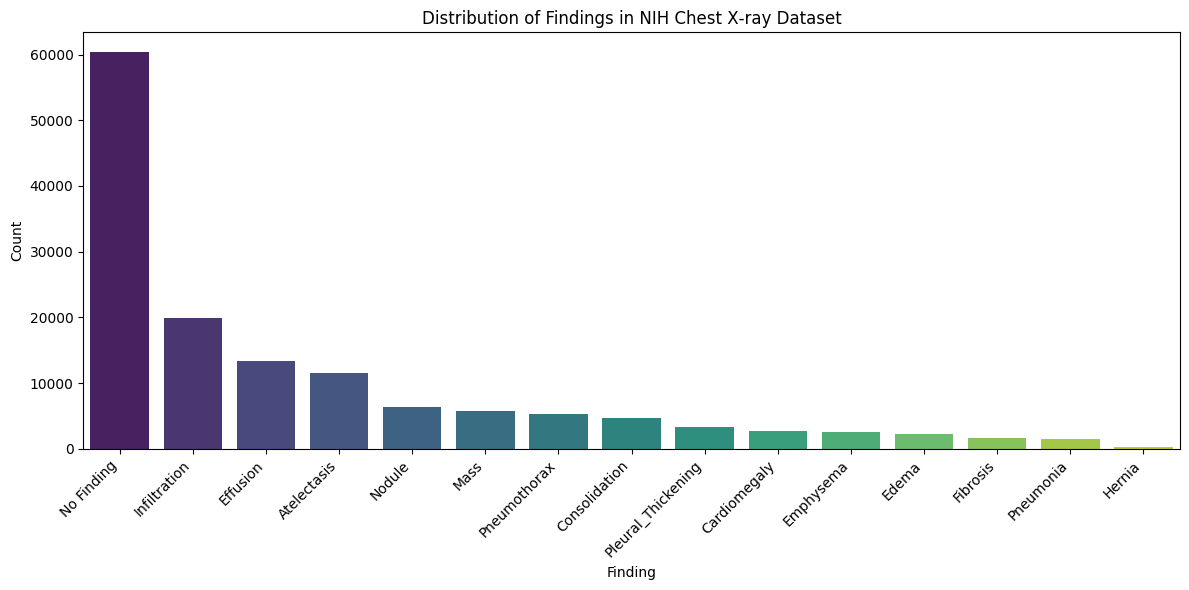

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x=labels_df.index, y=labels_df['Count'], palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Findings in NIH Chest X‑ray Dataset')
plt.xlabel('Finding')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

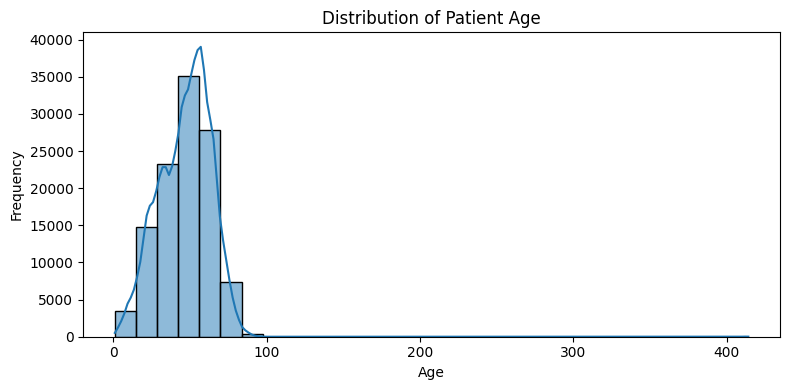

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(metadata['Patient Age'].dropna(), kde=True, bins=30)
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<ipython-input-14-711b6a5bf1ed>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Patient Gender', data=metadata, palette='Set2')


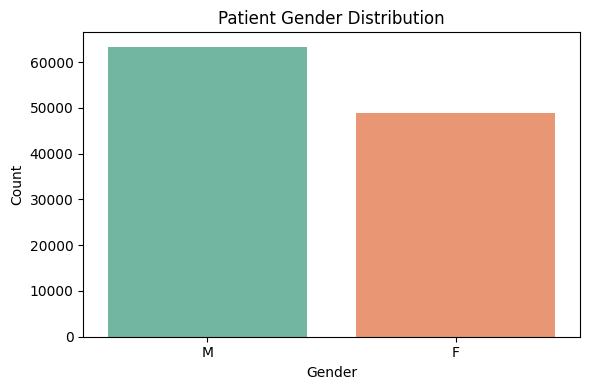

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Gender', data=metadata, palette='Set2')
plt.title('Patient Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Co-occurrence Analysis of Findings

In this section, we compute a co-occurrence matrix to analyze how often different findings appear together in the dataset. This helps to understand relationships between various pathological findings.

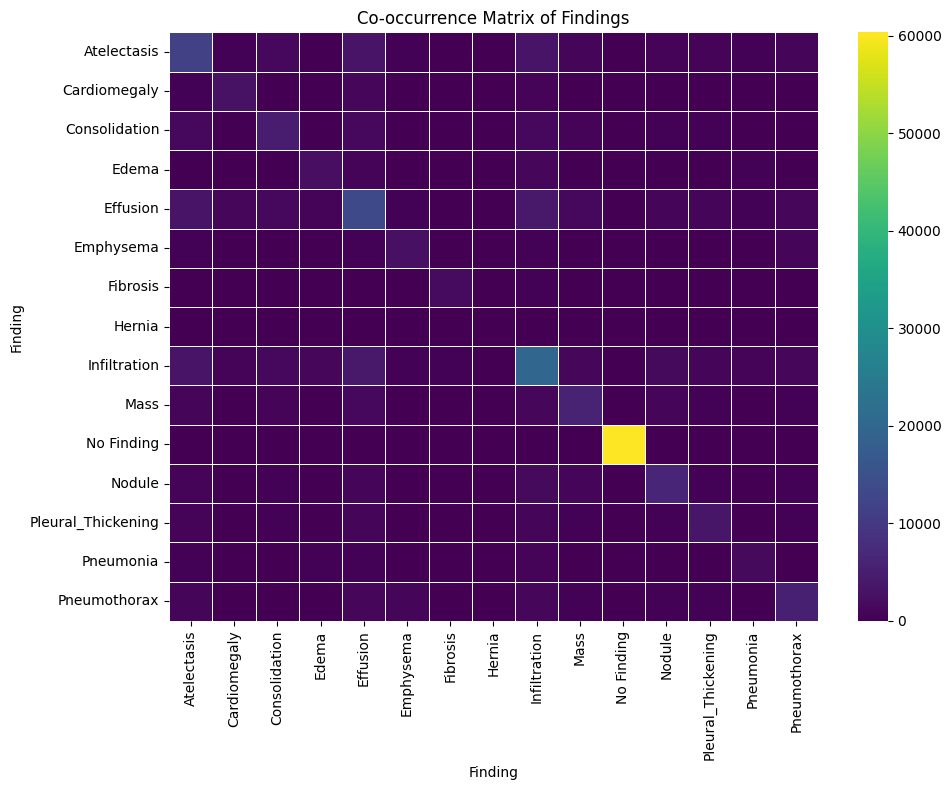

In [15]:
import itertools

# Get a sorted list of unique findings
unique_findings = sorted(list(all_labels.unique()))

# Initialize a DataFrame for the co-occurrence matrix
co_occurrence = pd.DataFrame(0, index=unique_findings, columns=unique_findings)

# Populate the matrix by iterating over each record
for labels in metadata['Finding Labels'].dropna():
    label_list = labels.split('|')
    # Update counts for each combination of findings
    for label1, label2 in itertools.combinations(label_list, 2):
        co_occurrence.loc[label1, label2] += 1
        co_occurrence.loc[label2, label1] += 1
    # Also increment self-occurrence for each label
    for label in label_list:
        co_occurrence.loc[label, label] += 1

# Plot the co-occurrence heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence, cmap='viridis', linewidths=0.5)
plt.title('Co-occurrence Matrix of Findings')
plt.xlabel('Finding')
plt.ylabel('Finding')
plt.tight_layout()
plt.show()



---



## Model Setup

In this section, we will create a train-test split and build a classification task. For demonstration purposes, we will use a simplified binary classification:

- **Normal vs. Abnormal:**  
  We define images with the label "No Finding" as *Normal* (0) and those with any other findings as *Abnormal* (1).

We will use patient demographics (e.g., Age and Gender) as features. Note that in practice you would typically extract image features from the actual chest X‑ray images, but here we use available metadata for demonstration.

We will then train:
- A baseline model using a `DummyClassifier`.
- A Support Vector Machine (SVM) classifier with an RBF kernel.
- Hyperparameter tuning will be performed using GridSearchCV.

Finally, we compare both models using classification metrics such as accuracy, precision, recall, and F1-score.
